# 12. Image registration

Image registration consists in aligning two images so that objects in them can be "aligned". This alignement can occur in space, as for example in the case of tomography where successive stacks are slightly shifted, or in time, for example when there is drift in a time-lapse acquisition.

There are many methods, more or less complicated to do this registration, which can involve shits, rotation and deformation. Here we are going to illustrate two of them: a simple one using a reference object in the image  and another one where series of "landmarks" are automatically detected.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

from skimage.feature import match_template
from skimage.filters import threshold_otsu

plt.gray();

<Figure size 432x288 with 0 Axes>

## 12.1 The data
The data used here are extracted from a microscopy experiment where bacterial cells are growing inside microfluidics channels over several hours (see [this paper](https://elifesciences.org/articles/48063) for details). To track those cells the channels need to be aligned over time. Here we load to time points and try to register them. Of course, this task should be repeated for all time points in a complete analysis. Here we also restrict the alignement to a portion of the images to facilitate visualisation:

In [2]:
image1 = io.imread('../Data/channels/channels1.tif')[0:750,:]
image2 = io.imread('../Data/channels/channels2.tif')[0:750,:]

Here are the two images as well as their subtraction that clearly shows a shift. The microfluidics channels are the small horizontal lines. The gray objects within them are bacteria (E.coli). The number on the left is a reference embedded in the device.

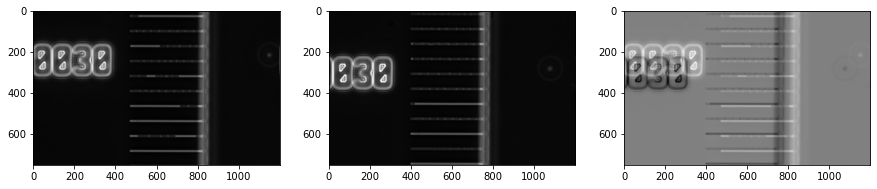

In [3]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(image1)
ax[1].imshow(image2)
ax[2].imshow(image1.astype(float)-image2.astype(float));

## 12.2 Template matching with chosen landmark

The first solution is to select a prominent feature in the image and use it as reference point for registration. Of course it should be a feature that only occurs a single time in every image (any repetitive feature like the channels themselves would not work). The obvious candidate to use here are the numbers on the left of the image. In particular the number three that appears a single time. Let's crop it out a region around the center of that number:

In [4]:
template_center = [250,250]
reference_region = image1[
    template_center[0]-50:template_center[0]+50,
    template_center[1]-50:template_center[1]+50
]

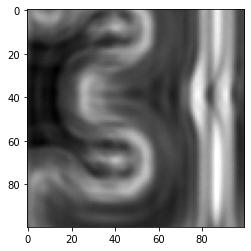

In [5]:
plt.imshow(reference_region);

Now we can use template matching that we discussed in a [previous chapter](08-Pattern-matching.ipynb) to find where that region is located in the second image. Note that we used the ```pad_input=True``` option: in this way the matched-image has the same size as the original image, and we easily can find the matching position.

In [6]:
matched = match_template(image2, reference_region, pad_input=True)

This is how the matched image looks like. There's as clear intense spot where we expect our match to be:

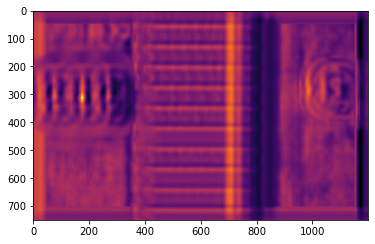

In [7]:
plt.imshow(matched, cmap = 'inferno');

We can now simply find the position of the brightest pixel in the matched-image. We use for that the ```np.argmax()``` function:

In [8]:
maxpos = np.argmax(matched)
maxpos

374576

We see however that this only returns a **linear** index, i.e. the index of the pixel in a *flattened* array where all dimensions have been concateneted. To recover the row and column indices, we need to transform that linear index into a 2D index using the ```np.unravel_index()``` function which takes as parameter the shape of the image:

In [9]:
maxpos = np.unravel_index(maxpos, matched.shape)
maxpos

(312, 176)

Let's now see if that point is correct:

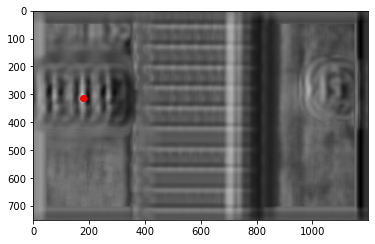

In [10]:
plt.imshow(matched)
plt.plot([maxpos[1]],[maxpos[0]],'ro');

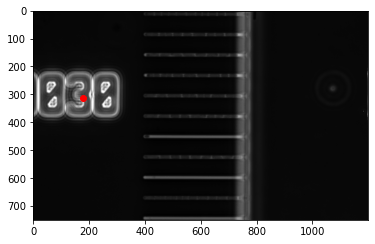

In [11]:
plt.imshow(image2)
plt.plot([maxpos[1]],[maxpos[0]],'ro');

The displacement is naturally the vector from the center of the tempalte that we croped out at the beginning and this maximum location:

In [12]:
displacement = template_center - np.array(maxpos)
print(displacement)

[-62  74]


The cleanest way to perform the shift is to slice/pad rows and columns. In that case we need to be careful about the sign of the displacement. If we don't care too much about the image edges, as for example here where our object of interest is in the image center, we can just shift or ```np.roll()``` elements:

In [13]:
image2_shift = np.roll(image2, shift = displacement, axis = (0,1))

We can now verify that the registration worked by calculating again the subtraction of the first image and the registered second image:

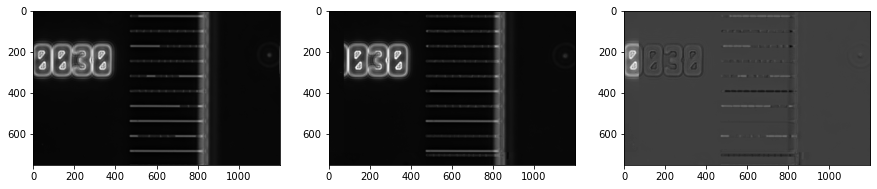

In [14]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(image1)
ax[1].imshow(image2_shift)
ax[2].imshow(image1.astype(float)-image2_shift.astype(float));

We see that the alignement worked well. The only remaining differences in intensity are the channels where bacteria are growing and moving.

## 12.3 General approach

In our first approach we had to manually select a reference object. That approach is also limited to finding simple translations. A more general approach to the problem is to let an algorithm find for us points of interest that can serve as landmarks for registration. In particular those landmarks should be "immune" to image transformations such as rotations, affine transformations etc. There are several feature detectors and some of them are implemented in skimage. Here we are using the [ORB](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.ORB) feature detection.

In [15]:
from skimage.feature import ORB, match_descriptors, plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform

The first step is to detect features in the two images we wish to register. The hope is that most of them will be found in both images. We create two ```ORB``` objects:

In [16]:
detector_extractor1 = ORB(n_keypoints=200)
detector_extractor2 = ORB(n_keypoints=200)

Then we apply them to the two images and extract the keypoints and descriptors. The keypoints are the coordinates of all locations that have been chosen as landmarks. The descriptors are series of binary values for each keypoint that describe the local environment. Imagine for example that one descriptor might say whether a point is right-angle or not.

In [17]:
detector_extractor1.detect_and_extract(image1)
keypoints1 = detector_extractor1.keypoints
descriptors1 = detector_extractor1.descriptors


detector_extractor2.detect_and_extract(image2)
keypoints2 = detector_extractor2.keypoints
descriptors2 = detector_extractor2.descriptors

If we visualize the descriptors we see that we have 256 binary descriptors for each of our 200 keypoints:

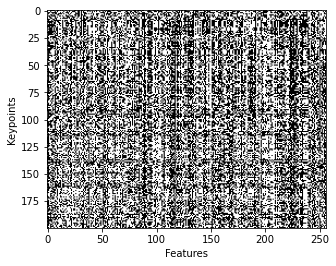

In [18]:
fig, ax = plt.subplots()
plt.imshow(descriptors1)
ax.set_xlabel('Features')
ax.set_ylabel('Keypoints');

Now that we have series of keypoints for both images, we need to pair them according to their descriptors by trying to maximize their "resemblance". We use the ```match_descriptors()``` for that:

In [19]:
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

We can represent those pairs of keypints by displaying both images and connecting those pairs with a line:

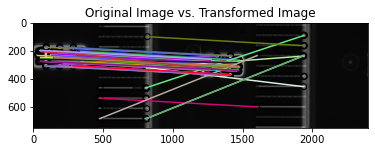

In [20]:
fig, ax = plt.subplots()
plot_matches(ax, image1, image2, keypoints1, keypoints2, matches12)
ax.set_title("Original Image vs. Transformed Image");

There is a clear cluster of lines that seem to give appropriate pairs. Note that most of the keypoints are situated in the "number-region" of the image as that region contains the most salient features. Let's now recover the coordinates of those pairs using ```matches12``` which is just a list of pairs of indices:

In [21]:
coords1 = keypoints1[matches12[:, 0]]
coords2 = keypoints2[matches12[:, 1]]

We can naively calculate an affine transformation that would optimize the match between these coordinates. For that we use the the ```AffineTransform``` object from skimage. The ```estimate``` function of ```AffineTransform``` takes two series of coordinates and finds the optimal transformation, including rotation, translation and scaling:

In [22]:
model = AffineTransform()
model.estimate(coords2, coords1)

True

Here are the numbers that we get:

In [23]:
print(f'Scale : {model.scale}')
print(f'Translation : {model.translation}')
print(f'Rotation : {model.rotation}')

Scale : (9.144090988890659, 1.0404898421429243)
Translation : [-2169.2502883   1615.00351007]
Rotation : -0.5950501047693328


Compared with the translation that we obained with the previous method, we see that clearly something went wrong:

In [24]:
displacement

array([-62,  74])

The probleme here is that the optimal affine transform has to take into account the few outliers that we observed before: we had a series of mostly parallel vectors and a few obviously mis-paired ones which make the optimization fail. How can we remove those points ? In principle we could try to come up with a custom solution where we try to select a group of vectors with similar orientations. However this is a good example where a more general solution based on statistical testing work well. Since our keypoint-pairs consist of a large majority of "good" pairs and a few "bad" outliers, we can use the [RANSAC](https://en.wikipedia.org/wiki/RANSAC) algorithm to optimize our affine transform. Essentially, the RANSAC algorithm fits a model to subsets of samples and keeps the best fit. As we only have a few outliers, there's a good chance that one subset will consist only of "good" keypoint-pairs and give the optimal result:

In [25]:
model_robust, inliers = ransac((coords2, coords1), AffineTransform, min_samples=3,
                               residual_threshold=0.01,max_trials=1000)

In [26]:
print(model_robust.scale, model_robust.translation, model_robust.rotation)


(1.0000000000000002, 1.0000000000000004) [-62.208   74.6496] -2.884444029575346e-16


Now we are back to a more reasonable result. Note that the method is probabilistic and doesn't always yield the same result.